### Initalizing spark

In [1]:
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.ml.linalg import DenseVector
import pyspark.sql.functions as F
import seaborn as sns
import matplotlib.pyplot as plt
import pyspark.sql.types as typ
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


import re
import pandas as pd

from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("Jonas_rentalPrice-Copy1") \
    .config("spark.executor.memory", '4g') \
    .config('spark.executor.cores', '1') \
    .config('spark.cores.max', '1') \
    .config("spark.driver.memory",'1g') \
    .getOrCreate()

sc = spark.sparkContext
sqlCtx = SQLContext(sc)

Downloading the data as a pandas data frame.

In [2]:
train_data_pd = pd.read_json("data/train.json")

Taking a look at the data.

In [3]:
train_data_pd

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address,interest_level
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],40.7145,7211212,-73.9425,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue,medium
10000,1.0,2,c5c8a357cba207596b04d1afd1e4f130,2016-06-12 12:19:27,,Columbus Avenue,"[Doorman, Elevator, Fitness Center, Cats Allow...",40.7947,7150865,-73.9667,7533621a882f71e25173b27e3139d83d,[https://photos.renthop.com/2/7150865_be3306c5...,5465,808 Columbus Avenue,low
100004,1.0,1,c3ba40552e2120b0acfc3cb5730bb2aa,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,"[Laundry In Building, Dishwasher, Hardwood Flo...",40.7388,6887163,-74.0018,d9039c43983f6e564b1482b273bd7b01,[https://photos.renthop.com/2/6887163_de85c427...,2850,241 W 13 Street,high
100007,1.0,1,28d9ad350afeaab8027513a3e52ac8d5,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,"[Hardwood Floors, No Fee]",40.7539,6888711,-73.9677,1067e078446a7897d2da493d2f741316,[https://photos.renthop.com/2/6888711_6e660cee...,3275,333 East 49th Street,low
100013,1.0,4,0,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,[Pre-War],40.8241,6934781,-73.9493,98e13ad4b495b9613cef886d79a6291f,[https://photos.renthop.com/2/6934781_1fa4b41a...,3350,500 West 143rd Street,low
100014,2.0,4,38a913e46c94a7f46ddf19b756a9640c,2016-04-19 04:24:47,,West 18th Street,[],40.7429,6894514,-74.0028,b209e2c4384a64cc307c26759ee0c651,[https://photos.renthop.com/2/6894514_9abb8592...,7995,350 West 18th Street,medium
100016,1.0,2,3ba49a93260ca5df92fde024cb4ca61f,2016-04-27 03:19:56,Stunning unit with a great location and lots o...,West 107th Street,"[prewar, elevator, Dogs Allowed, Cats Allowed,...",40.8012,6930771,-73.9660,01287194f20de51872e81f660def4784,[https://photos.renthop.com/2/6930771_7e3622b6...,3600,210 West 107th Street,low
100020,2.0,1,0372927bcb6a0949613ef5bf893bbac7,2016-04-13 06:01:42,"This huge sunny ,plenty of lights 1 bed/2 bath...",West 21st Street,"[Doorman, Elevator, Pre-War, Terrace, Laundry ...",40.7427,6867392,-73.9957,e6472c7237327dd3903b3d6f6a94515a,[https://photos.renthop.com/2/6867392_b18283f6...,5645,155 West 21st Street,low
100026,1.0,1,a7efbeb58190aa267b4a9121cd0c88c0,2016-04-20 02:36:35,<p><a website_redacted,Hamilton Terrace,"[Cats Allowed, Dogs Allowed, Elevator, Laundry...",40.8234,6898799,-73.9457,c1a6598437b7db560cde66e5a297a53f,[https://photos.renthop.com/2/6898799_3759be4c...,1725,63 Hamilton Terrace,medium
100027,2.0,4,0,2016-04-02 02:58:15,This is a spacious four bedroom with every bed...,522 E 11th,"[Dishwasher, Hardwood Floors]",40.7278,6814332,-73.9808,23a01ea7717b38875f5b070282d1b9d2,[https://photos.renthop.com/2/6814332_e19a8552...,5800,522 E 11th,low


Create a pySpark DataFrame of the pandas Data Frame.

In [4]:
train_data_df = sqlCtx.createDataFrame(train_data_pd)
train_data_df.cache()

DataFrame[bathrooms: double, bedrooms: bigint, building_id: string, created: string, description: string, display_address: string, features: array<string>, latitude: double, listing_id: bigint, longitude: double, manager_id: string, photos: array<string>, price: bigint, street_address: string, interest_level: string]

Printing the schema. Seems to be ok for most part. The `created` should be changed from string to time object.

In [5]:
train_data_df.printSchema()

root
 |-- bathrooms: double (nullable = true)
 |-- bedrooms: long (nullable = true)
 |-- building_id: string (nullable = true)
 |-- created: string (nullable = true)
 |-- description: string (nullable = true)
 |-- display_address: string (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- latitude: double (nullable = true)
 |-- listing_id: long (nullable = true)
 |-- longitude: double (nullable = true)
 |-- manager_id: string (nullable = true)
 |-- photos: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- price: long (nullable = true)
 |-- street_address: string (nullable = true)
 |-- interest_level: string (nullable = true)



Show the first row in the pySpark Data Frame.

In [6]:
train_data_df.show(1)

+---------+--------+--------------------+-------------------+--------------------+-------------------+--------+--------+----------+---------+--------------------+--------------------+-----+--------------------+--------------+
|bathrooms|bedrooms|         building_id|            created|         description|    display_address|features|latitude|listing_id|longitude|          manager_id|              photos|price|      street_address|interest_level|
+---------+--------+--------------------+-------------------+--------------------+-------------------+--------+--------+----------+---------+--------------------+--------------------+-----+--------------------+--------------+
|      1.5|       3|53a5b119ba8f7b61d...|2016-06-24 07:54:24|A Brand New 3 Bed...|Metropolitan Avenue|      []| 40.7145|   7211212| -73.9425|5ba989232d0489da1...|[https://photos.r...| 3000|792 Metropolitan ...|        medium|
+---------+--------+--------------------+-------------------+--------------------+--------------

Printing the `bathrooms` column and sorting on the most frequent number of bathrooms.

In [7]:
train_data_df.groupBy('bathrooms').count().sort('count', ascending=False).show()

+---------+-----+
|bathrooms|count|
+---------+-----+
|      1.0|39422|
|      2.0| 7660|
|      3.0|  745|
|      1.5|  645|
|      0.0|  313|
|      2.5|  277|
|      4.0|  159|
|      3.5|   70|
|      4.5|   29|
|      5.0|   20|
|      5.5|    5|
|      6.0|    4|
|      7.0|    1|
|      6.5|    1|
|     10.0|    1|
+---------+-----+



Checking out the apartment with 10 bathrooms.

In [8]:
train_data_df.filter(train_data_df["bathrooms"] == 10.0).show()

+---------+--------+--------------------+-------------------+--------------------+---------------+--------------------+--------+----------+---------+--------------------+--------------------+-----+--------------+--------------+
|bathrooms|bedrooms|         building_id|            created|         description|display_address|            features|latitude|listing_id|longitude|          manager_id|              photos|price|street_address|interest_level|
+---------+--------+--------------------+-------------------+--------------------+---------------+--------------------+--------+----------+---------+--------------------+--------------------+-----+--------------+--------------+
|     10.0|       2|424f8014bddc288d2...|2016-04-09 04:34:31|***The building?s...|       W 52 St.|[Doorman, Elevato...| 40.7633|   6849204| -73.9849|0c71a59cb70215fbf...|[https://photos.r...| 3600|  260 W 52 St.|           low|
+---------+--------+--------------------+-------------------+--------------------+------

We we that it is a room with 2 bedrooms. Highly likely that it is a typo. We continue to check out the rental with 7 and 6.5 bathrooms.

In [9]:
train_data_df.filter((train_data_df["bathrooms"] == 7.0) | (train_data_df["bathrooms"] == 6.5) ).show()

+---------+--------+--------------------+-------------------+--------------------+--------------------+--------------------+--------+----------+---------+--------------------+--------------------+-----+--------------------+--------------+
|bathrooms|bedrooms|         building_id|            created|         description|     display_address|            features|latitude|listing_id|longitude|          manager_id|              photos|price|      street_address|interest_level|
+---------+--------+--------------------+-------------------+--------------------+--------------------+--------------------+--------+----------+---------+--------------------+--------------------+-----+--------------------+--------------+
|      6.5|       7|3be1175591e290053...|2016-06-22 03:15:54|This landmark Eng...|206 Upper Mountai...|[Garage, Garden, ...| 40.8336|   7198431|  -74.216|1d019cccf631394cd...|[https://photos.r...|14500|206 Upper Mountai...|           low|
|      7.0|       5|                   0|201

We see that these are way more expensive than the rental with 10 bathrooms which further the suspision that it is a typo. 

Printing the `bedrooms` column and sorting on the most frequent number of bedrooms.

In [10]:
train_data_df.groupBy('bedrooms').count().sort('count', ascending=False).show()

+--------+-----+
|bedrooms|count|
+--------+-----+
|       1|15752|
|       2|14623|
|       0| 9475|
|       3| 7276|
|       4| 1929|
|       5|  247|
|       6|   46|
|       7|    2|
|       8|    2|
+--------+-----+



Check out the 8 room apartments.

In [11]:
train_data_df.filter((train_data_df["bedrooms"] == 8)).show()

+---------+--------+--------------------+-------------------+--------------------+----------------+--------------------+--------+----------+---------+--------------------+--------------------+-----+----------------+--------------+
|bathrooms|bedrooms|         building_id|            created|         description| display_address|            features|latitude|listing_id|longitude|          manager_id|              photos|price|  street_address|interest_level|
+---------+--------+--------------------+-------------------+--------------------+----------------+--------------------+--------+----------+---------+--------------------+--------------------+-----+----------------+--------------+
|      4.0|       8|2d51ec2a54cf05468...|2016-06-25 06:09:20|Gorgeous 8 bedroo...|      Greene Ave|[Hardwood Floors,...| 40.6881|   7217045| -73.9553|9ba3641676cc717a8...|                  []| 6500|  393 Greene Ave|           low|
|      3.0|       8|f8bff653aae7c7555...|2016-06-13 02:47:37|Please note tha

We check for the `building_id` and conclude that we have 8286 missing values here.

fjdklfjdafjldöföjl da `heaj ` dsadsa  __ewqeqw__ 

In [12]:
train_data_df.groupBy('building_id').count().sort('count', ascending=False).show(5)

+--------------------+-----+
|         building_id|count|
+--------------------+-----+
|                   0| 8286|
|96274288c84ddd7d5...|  275|
|11e1dec9d14b1a9e5...|  215|
|80a120d6bc3aba97f...|  213|
|bb8658a3e432fb62a...|  212|
+--------------------+-----+
only showing top 5 rows



Displaying the `created` column.

In [13]:
train_data_df[["created"]].show(5)

+-------------------+
|            created|
+-------------------+
|2016-06-24 07:54:24|
|2016-06-12 12:19:27|
|2016-04-17 03:26:41|
|2016-04-18 02:22:02|
|2016-04-28 01:32:41|
+-------------------+
only showing top 5 rows



Changing the `created` column to timestamp objects instead of strings.

In [14]:
train_data_df = train_data_df.withColumn("created", F.to_timestamp("created"))
train_data_df.cache()

DataFrame[bathrooms: double, bedrooms: bigint, building_id: string, created: timestamp, description: string, display_address: string, features: array<string>, latitude: double, listing_id: bigint, longitude: double, manager_id: string, photos: array<string>, price: bigint, street_address: string, interest_level: string]

We create a coulm called `Day_of_week` which contains the day of the week the rental was created.

In [15]:
day_of_week = train_data_df.withColumn("Day_of_week", F.dayofweek(train_data_df["created"]))
day_of_week = day_of_week[["Day_of_week"]]
day_of_week.show(5)

+-----------+
|Day_of_week|
+-----------+
|          6|
|          1|
|          1|
|          2|
|          5|
+-----------+
only showing top 5 rows



We want to plot the count of the different days that the rental was created.

In [16]:
day_of_week_pd = day_of_week.toPandas()

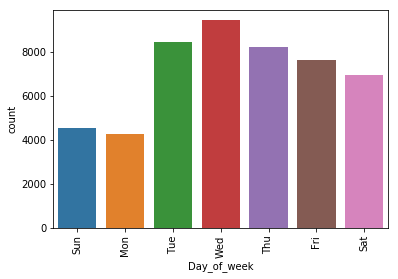

In [17]:
ax = sns.countplot(x="Day_of_week", data = day_of_week_pd)
ax.set_xticklabels(["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"], rotation='vertical', fontsize=10)
plt.show()

We create a data frame with `longitude` and `latitude` in order to plot the positioning of the rental unit on a map.

In [18]:
long_lat_df = train_data_df[["longitude", "latitude"]]
long_lat_df.cache()

DataFrame[longitude: double, latitude: double]

In [19]:
long_lat_df.show(5)

+---------+--------+
|longitude|latitude|
+---------+--------+
| -73.9425| 40.7145|
| -73.9667| 40.7947|
| -74.0018| 40.7388|
| -73.9677| 40.7539|
| -73.9493| 40.8241|
+---------+--------+
only showing top 5 rows



Printing a statistic summary, mostly to see if there were any strange values. Which there were since we dont think that there are any rental units with longitude and latitude = 0.0

In [20]:
long_lat_df.describe().show()

+-------+------------------+------------------+
|summary|         longitude|          latitude|
+-------+------------------+------------------+
|  count|             49352|             49352|
|   mean|-73.95571552115474| 40.74154482290508|
| stddev|1.1779119215716662|0.6385353439544775|
|    min|          -118.271|               0.0|
|    max|               0.0|           44.8835|
+-------+------------------+------------------+



We see how many rental units that have longitude and latitude = 0.0

In [21]:
print("Number of observations with missing longitude: {}" .format(long_lat_df.filter(long_lat_df["longitude"] == 0.0).count()))
print("Number of observations with missing latitude: {}" .format(long_lat_df.filter(long_lat_df["latitude"] == 0.0).count()))

Number of observations with missing longitude: 12
Number of observations with missing latitude: 12


Could these be the same observations?

In [22]:
print("Number of observations with missing longitude and latitude: {}".format(long_lat_df.filter((long_lat_df["latitude"] == 0.0) & (long_lat_df["longitude"] == 0.0)).count()))

Number of observations with missing longitude and latitude: 12


Yes they are... So how many are remaining?

In [23]:
long_lat_df.filter(long_lat_df["latitude"] != 0.0).count()

49340

To plot the apartments we use the package `folium` which can make interactive plots and we can get more information of the rental units in the plot.

Inspiration from blogpost: https://nbviewer.jupyter.org/github/vincentropy/python_cartography_tutorial/blob/master/part1_basic_folium_maps.ipynb

In [24]:
!pip install --upgrade folium
import folium

Requirement already up-to-date: folium in /opt/conda/lib/python3.6/site-packages (0.7.0)
You are using pip version 19.0.2, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


We create a function that places each of the units on the map. The color of the apartment corresponds to the factor `interest_level` which has not been investigated thoroughly yet. The size of the circle is based on the price which can be displayed by *klicking* the circle, along with the `street_address`.

In [25]:
def plot_rental_locatinos(rental_locatinos):
        # generate a new map
    folium_map = folium.Map(location=[40.738, -73.98],
                            zoom_start=13,
                            tiles="CartoDB dark_matter",
                            width='50%')

            
    for index, row in rental_locatinos.iterrows():
        
            popup_text = "{}<br> Price: {}<br>"
            popup_text = popup_text.format(row["street_address"], row["price"])
            
            if row["interest_level"] == 'high':
                color="#00FF00" # green
            if row["interest_level"] == 'medium':
                color="#FFFF00" # yellow 
            if row["interest_level"] == 'low':
                color="#FF6347" # red
                
            radius = row["price"]/1000
        
            folium.CircleMarker(location=(row["latitude"],
                                      row["longitude"]),
                            radius=radius,
                            color=color,
                            popup=popup_text,
                            fill=True).add_to(folium_map)
    return folium_map

Since our data set is too big for all rental units to be displayed a subsample of 1000 units are changed into a pandas data frame which is then plotted using the above constructed function `plot_rental_locatinos`.

In [26]:
sample_pd = train_data_pd.sample(n = 1000)

The user constructed function `plot_rental_locatinos`

In [27]:
plot_rental_locatinos(sample_pd)

421 Hudson Street
Price: 4490000

# `features`

The goal here is to divide the different individual features into different clusters. And make 1 new column per cluster in the data set and then fit a regression model on the clusters.

We have to handle the rentals with missing featurses by adding `missing feature` as a feature. Here are the 2 first listings with missing features.

In [28]:
train_data_df.filter(F.size("features")==0)[["listing_id", "features"]].show(2)

+----------+--------+
|listing_id|features|
+----------+--------+
|   7211212|      []|
|   6894514|      []|
+----------+--------+
only showing top 2 rows



But first since the column `features` is a list containing strings, we want to mearge the list of strings to one string. We do this by constructing a `UserDefinedFunction` named `string_assembler` which uses the `','.join()` to join strings in a list and separating them with a **,** . This is what we do: \['dog', 'cat'\] -> 'dog,cat'.

In [29]:
string_assembler = F.UserDefinedFunction(lambda x: ','.join(x), typ.StringType())

The function `string_assembler` is used on the column `features`.

In [30]:
train_data_df = train_data_df.withColumn("features", string_assembler(train_data_df["features"]))
train_data_df.cache()

DataFrame[bathrooms: double, bedrooms: bigint, building_id: string, created: timestamp, description: string, display_address: string, features: string, latitude: double, listing_id: bigint, longitude: double, manager_id: string, photos: array<string>, price: bigint, street_address: string, interest_level: string]

All strings are set to lower case.

In [31]:
train_data_df = train_data_df.withColumn("features", F.lower(train_data_df["features"]))

A display of what we have done. Note that the first row is missing any `features`. This is valuable information as well since a listing ad without information about the rental place could determin the popularity of the place.

In [32]:
train_data_df[["features"]].show(5)

+--------------------+
|            features|
+--------------------+
|                    |
|doorman,elevator,...|
|laundry in buildi...|
|hardwood floors,n...|
|             pre-war|
+--------------------+
only showing top 5 rows



We impute all missing `features` with the string "missing feature".

In [33]:
train_data_df = train_data_df.withColumn("features", 
                             F.when(train_data_df["features"] == '', 'missing features')
                             .otherwise(train_data_df["features"]))

The results are shown.

In [34]:
train_data_df[["features"]].show(5)

+--------------------+
|            features|
+--------------------+
|    missing features|
|doorman,elevator,...|
|laundry in buildi...|
|hardwood floors,n...|
|             pre-war|
+--------------------+
only showing top 5 rows



We want to split the `features` string on **","** and on __"*"__ since some listings had all features in one long string with * separating the different features. 

In [35]:
feat_df = train_data_df.withColumn("features_list", F.split(train_data_df["features"], ',| \* '))

The results are shown.

In [36]:
feat_df[["features_list"]].show(5)

+--------------------+
|       features_list|
+--------------------+
|  [missing features]|
|[doorman, elevato...|
|[laundry in build...|
|[hardwood floors,...|
|           [pre-war]|
+--------------------+
only showing top 5 rows



Now we want to create one feature be uniqe feature in the `features`. The first step is to 'explode' the features so that each single feature gets it's own row. (To see the tables go into edit mode(press Enter))

+----------+---------------+       +----------+---------------+
|listing_id|   col_list    |       |listing_id|  ex_col_list  |
+----------+---------------+    -> +----------+---------------+ 
|  12345   |"item1","item2"|       |  12345   |   "item1"     |
+----------+---------------+       |  12345   |   "item2"     |
                                   +----------+---------------+ 

In [37]:
feat_df_ex = feat_df.withColumn("ex_features_list", F.explode(feat_df["features_list"]))

We create a data frame called `clustering_df` which contains all different featurese.

In [38]:
clustering_df = feat_df_ex[["ex_features_list"]]
clustering_df.cache()
clustering_df.show(5)

+----------------+
|ex_features_list|
+----------------+
|missing features|
|         doorman|
|        elevator|
|  fitness center|
|    cats allowed|
+----------------+
only showing top 5 rows



Change the name of the column from "ex_features_list" to "text".

In [39]:
clustering_df = clustering_df.withColumnRenamed("ex_features_list", "text")
clustering_df.columns

['text']

Here we create a new data frame `pipelined_df`. All different features are being tokenized, stop words are removed (and maybe should be left in), the tokens are hashed and an output column `features` that we are going to use.

In [40]:
from pyspark.ml.feature import HashingTF, IDF, Tokenizer, CountVectorizer, StopWordsRemover
from pyspark.ml.pipeline import Pipeline

tokenizer = Tokenizer(inputCol="text", outputCol="tokens")
remover = StopWordsRemover(inputCol="tokens", outputCol="stopWordsRemovedTokens")
hashingTF = HashingTF(inputCol="stopWordsRemovedTokens", outputCol="rawFeatures", numFeatures=2000)
idf = IDF(inputCol="rawFeatures", outputCol="features", minDocFreq=5)

pipeline = Pipeline(stages=[tokenizer, remover, hashingTF, idf])
pipelined_df = pipeline.fit(clustering_df).transform(clustering_df)

The data frame can be seen here:

In [41]:
pipelined_df.show(5)

+----------------+-------------------+----------------------+--------------------+--------------------+
|            text|             tokens|stopWordsRemovedTokens|         rawFeatures|            features|
+----------------+-------------------+----------------------+--------------------+--------------------+
|missing features|[missing, features]|   [missing, features]|(2000,[1525,1755]...|(2000,[1525,1755]...|
|         doorman|          [doorman]|             [doorman]|  (2000,[825],[1.0])|(2000,[825],[2.55...|
|        elevator|         [elevator]|            [elevator]|   (2000,[31],[1.0])|(2000,[31],[2.335...|
|  fitness center|  [fitness, center]|     [fitness, center]|(2000,[1173,1966]...|(2000,[1173,1966]...|
|    cats allowed|    [cats, allowed]|       [cats, allowed]|(2000,[1350,1966]...|(2000,[1350,1966]...|
+----------------+-------------------+----------------------+--------------------+--------------------+
only showing top 5 rows



We are not reay to cluseter the data frame `pipelined_df` which by default uses K-means on the column `features`. `BisectingKMeans` is used for clustering. It was choosen since the normal K-means clustered allmost all observations in the same cluster while `BisectingKMeans` had the observations more eavenly spread out over different clusters.

To find the best number of clusters `k` the elbow method is used. This line of code takes time to run!!! And could be skiped, just set k = 20 approx.

In [42]:
from pyspark.ml.clustering import BisectingKMeans
import timeit
start = timeit.default_timer()

Sum_of_squared_distances = []
K = range(2, 50, 10)

for i in K:
    km = BisectingKMeans(k = i)
    model = km.fit(pipelined_df)
    Sum_of_squared_distances.append(model.computeCost(pipelined_df))
    print(i)
    
stop = timeit.default_timer()
print('Time: ', stop - start) 

2
12
22
32
42
Time:  826.4920728610014


We can plot the results.

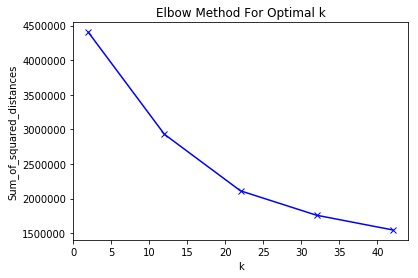

In [43]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

From the plot and the elbow method for optimal `k` indikates k = 20. 

In [44]:
num_k = 20

We train the model using the `k` choosen by the elbow method.

In [45]:
km = BisectingKMeans(k = num_k)
model = km.fit(pipelined_df)

The results are printed.

In [46]:
results = model.transform(pipelined_df)
results.cache()
results.show(5)

+----------------+-------------------+----------------------+--------------------+--------------------+----------+
|            text|             tokens|stopWordsRemovedTokens|         rawFeatures|            features|prediction|
+----------------+-------------------+----------------------+--------------------+--------------------+----------+
|missing features|[missing, features]|   [missing, features]|(2000,[1525,1755]...|(2000,[1525,1755]...|        14|
|         doorman|          [doorman]|             [doorman]|  (2000,[825],[1.0])|(2000,[825],[2.55...|         0|
|        elevator|         [elevator]|            [elevator]|   (2000,[31],[1.0])|(2000,[31],[2.335...|         0|
|  fitness center|  [fitness, center]|     [fitness, center]|(2000,[1173,1966]...|(2000,[1173,1966]...|        12|
|    cats allowed|    [cats, allowed]|       [cats, allowed]|(2000,[1350,1966]...|(2000,[1350,1966]...|         2|
+----------------+-------------------+----------------------+-------------------

The column default output column `precidtion` is changed to `clusters`.

In [47]:
results = results.withColumnRenamed("prediction", "clusters")

We drop the columns we don't need anymore.

In [48]:
join_df = results.drop(*["tokens", "stopWordsRemovedTokens", "rawFeatures", "features"])
join_df.show(2)

+----------------+--------+
|            text|clusters|
+----------------+--------+
|missing features|      14|
|         doorman|       0|
+----------------+--------+
only showing top 2 rows



Cheching if the features in `join_df` and `feat_df_ex` match. Seems to be okay.

In [49]:
print(join_df.collect()[1][0])
print(feat_df_ex[["ex_features_list"]].collect()[1][0])

print(join_df.collect()[1000][0])
print(feat_df_ex[["ex_features_list"]].collect()[1000][0])

doorman
doorman
hardwood floors
hardwood floors


Now we want to join the two data sets together and create a column to add on.

In [50]:
join_df = join_df.withColumn("join_col", F.monotonically_increasing_id())
feat_df_ex = feat_df_ex.withColumn("join_col", F.monotonically_increasing_id())

The 2 data frames are shown bellow.

In [51]:
join_df.show(3)
feat_df_ex[["ex_features_list", "join_col"]].show(3)

+----------------+--------+--------+
|            text|clusters|join_col|
+----------------+--------+--------+
|missing features|      14|       0|
|         doorman|       0|       1|
|        elevator|       0|       2|
+----------------+--------+--------+
only showing top 3 rows

+----------------+--------+
|ex_features_list|join_col|
+----------------+--------+
|missing features|       0|
|         doorman|       1|
|        elevator|       2|
+----------------+--------+
only showing top 3 rows



We join the 2 data frames based on the created column, which after the join is droped. The columns are displayed below.

In [52]:
joined_df = feat_df_ex.join(join_df, feat_df_ex["join_col"] == join_df["join_col"], how = "left")
joined_df = joined_df.drop("join_col")
joined_df.count()
joined_df.columns

['bathrooms',
 'bedrooms',
 'building_id',
 'created',
 'description',
 'display_address',
 'features',
 'latitude',
 'listing_id',
 'longitude',
 'manager_id',
 'photos',
 'price',
 'street_address',
 'interest_level',
 'features_list',
 'ex_features_list',
 'text',
 'clusters']

The columns `text` and `prediction` are shown.

In [53]:
joined_df[["text", "clusters"]].show(3)

+---------------+--------+
|           text|clusters|
+---------------+--------+
|laundry in unit|      11|
|  outdoor space|      18|
|laundry in unit|      11|
+---------------+--------+
only showing top 3 rows



Creating a dummy row containing only 1's for the `pivot` function we are about to use.

In [54]:
joined_df = joined_df.withColumn("constant_val", F.lit(1))

Grouping by `listing_id`, `pivot`ing so each feature in `ex_features_list` becomes it's own column containing either a 1 or 0. The `agg` fucntion is used since the `pivot` function creates a `pivot` object. Then `coalesce` is used to return a new DataFrame that has exactly `F.first("constant_val")` partitions. `F.first("constant_val")` is just to get the number of partitions `coalesce` needs.

In [55]:
df_piv = joined_df\
                   .groupBy("listing_id")\
                   .pivot("clusters")\
                   .agg(F.coalesce(F.first("constant_val")))
df_piv.cache()
df_piv.count()

49352

Checking the columns.

In [56]:
df_piv.columns

['listing_id',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19']

We now add the cluster column to the original data set and calls the data frame `joined_df`.

In [57]:
joined_df = train_data_df.join(df_piv, on = "listing_id", how = "left")
joined_df.cache()
print(joined_df.count())
print(len(joined_df.columns))

49352
35


We want to store all clusters in a list. We remove `listing_id` since it's not a clusters.

In [58]:
cluster_col = df_piv.columns
cluster_col.remove("listing_id")

We see that there are missing values.

In [59]:
joined_df[["1"]].show(3)

+----+
|   1|
+----+
|null|
|null|
|null|
+----+
only showing top 3 rows



We replace all new columns with 0's.

In [60]:
joined_df = joined_df.fillna(0, subset = cluster_col)

Missing values are now 0 instead.

In [61]:
joined_df[["1"]].show(3)

+---+
|  1|
+---+
|  0|
|  0|
|  0|
+---+
only showing top 3 rows



We create a data fram with only the `interest_level` and the clusters.

In [62]:
cols_to_drop = train_data_df.columns
cols_to_drop.remove("interest_level")
cluseters_df = joined_df.drop(*cols_to_drop)

The columns are shown.

In [63]:
cluseters_df.columns

['interest_level',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19']

The data frame is changed to a rdd to create a column with the lables and a column of dense vectors with the features.

In [64]:
imput_data = cluseters_df.rdd.map(lambda x: (x[0], DenseVector(x[1:])))
df_dense = sqlCtx.createDataFrame(imput_data, ['label','features'])

The lables are changed from _low, medium, high_ to 0,1,2 to be able to use logistic regression.

In [65]:
df_dense = df_dense.withColumn("label", F.when(df_dense["label"] == 'low', 0)
                                         .when(df_dense["label"] == 'medium', 1)
                                         .otherwise(2))
df_dense.cache()

DataFrame[label: int, features: vector]

We split the data set into a train set (80%) and a test set (20%).

In [66]:
(train, test) = df_dense.randomSplit(seed = 1337, weights = [0.8, 0.2])

A multinomial logistic regression model is created since we have 3 lables.

In [67]:
mlr = LogisticRegression(maxIter=10, family="multinomial")

We train the model on the training set.

In [68]:
mlrModel = mlr.fit(train)

training_results = mlrModel.transform(train)
training_results.cache()
training_results.show(3)

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|    0|[0.0,0.0,0.0,0.0,...|[1.12717172691868...|[0.71789707793259...|       0.0|
|    0|[0.0,0.0,0.0,0.0,...|[1.12717172691868...|[0.71789707793259...|       0.0|
|    0|[0.0,0.0,0.0,0.0,...|[1.12717172691868...|[0.71789707793259...|       0.0|
+-----+--------------------+--------------------+--------------------+----------+
only showing top 3 rows



The labels and predictions are casted to a pandas data frame train_confusion_matrix_pd.

In [69]:
train_confusion_matrix_pd = training_results.select("label", "prediction").toPandas()

We are interested in the **training error**.

In [70]:
test_results = mlrModel.transform(test)
test_results.cache()
test_results.show(3)

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|    0|[0.0,0.0,0.0,0.0,...|[1.12717172691868...|[0.71789707793259...|       0.0|
|    0|[0.0,0.0,0.0,0.0,...|[0.94883053146283...|[0.65664033816295...|       0.0|
|    0|[0.0,0.0,0.0,0.0,...|[0.91615926431611...|[0.65446471198453...|       0.0|
+-----+--------------------+--------------------+--------------------+----------+
only showing top 3 rows



The labels and predictions are casted to a pandas data frame test_confusion_matrix_pd.

In [71]:
test_confusion_matrix_pd = test_results.select("label", "prediction").toPandas()

We want to plot a nice looking confusion matrix. This is done by the function `plot_confusion_matrix` implemented bellow. The function is taken from https://scikit-learn.org and the link to the function is here: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html 

In [72]:
import numpy as np
import itertools

In [73]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


A confusion matrix is constructed using `sklearn.metrics.confusion_matrix`.

In [74]:
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(test_confusion_matrix_pd["label"], test_confusion_matrix_pd["prediction"])

The confusion matrix is shown.

Confusion matrix, without normalization
[[6848    1    2]
 [2308    1    2]
 [ 751    0    3]]


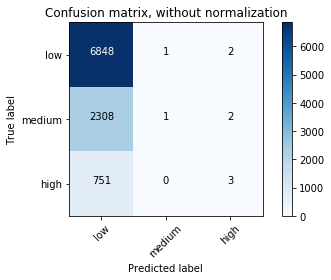

In [75]:
plt.figure()
class_names = ["low", "medium", "high"]
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize = False,
                      title='Confusion matrix, without normalization')

A fucntion is created to calculate the cross-entropy/-logloss.

In [76]:
from numpy import log

def log_loss(results_transformed, lables = "label", probability = "probability"):    
    labs_and_preds = results_transformed[lables, probability]
    
    return - labs_and_preds\
                .rdd\
                .map(lambda x: log(x[1][x[0]]))\
                .reduce(lambda x,y: x + y) / labs_and_preds.count()

The log loss is displayed.

In [77]:
log_loss(test_results)

0.7680681042601653

# `manager_id`

We are going to investigate the colum `manager_id`.

In [78]:
train_data_df[["manager_id"]].show(5)

+--------------------+
|          manager_id|
+--------------------+
|5ba989232d0489da1...|
|7533621a882f71e25...|
|d9039c43983f6e564...|
|1067e078446a7897d...|
|98e13ad4b495b9613...|
+--------------------+
only showing top 5 rows



We create a column `manager_idx` which just takes the column `manager_id` and maps it to a index.

In [79]:
from pyspark.ml.feature import StringIndexer

string_indexer = StringIndexer(inputCol = "manager_id", outputCol = "manager_idx")
manager_df = string_indexer.fit(train_data_df).transform(train_data_df)

The count is shown for the different managers based on their index.

In [80]:
manager_df[["manager_idx"]].groupBy("manager_idx").count().sort('count', ascending=False).show(5)
manager_df[["manager_idx"]].groupBy("manager_idx").count().sort('count', ascending=True).show(5)

+-----------+-----+
|manager_idx|count|
+-----------+-----+
|        0.0| 2533|
|        1.0|  711|
|        2.0|  410|
|        3.0|  402|
|        4.0|  373|
+-----------+-----+
only showing top 5 rows

+-----------+-----+
|manager_idx|count|
+-----------+-----+
|     2815.0|    1|
|     3345.0|    1|
|     3432.0|    1|
|     3029.0|    1|
|     2523.0|    1|
+-----------+-----+
only showing top 5 rows



We create a data frame `manager_join` with only the colum `manager_idx` and the count, i.e. the number of rentals they have uploaded.

In [81]:
manager_join = manager_df[["manager_idx"]].groupBy("manager_idx").count()

In [82]:
manager_join.show(4)

+-----------+-----+
|manager_idx|count|
+-----------+-----+
|      496.0|   23|
|      692.0|   16|
|     1051.0|   10|
|      305.0|   36|
+-----------+-----+
only showing top 4 rows



We create a new column `count` where the number of rentals for each manager is.

In [83]:
manager_df = manager_df.join(manager_join, on = "manager_idx", how = "left")

The results are shown.

In [84]:
manager_df[["manager_idx", "count"]].show(5)

+-----------+-----+
|manager_idx|count|
+-----------+-----+
|       78.0|   90|
|       83.0|   86|
|       38.0|  134|
|       22.0|  191|
|      752.0|   15|
+-----------+-----+
only showing top 5 rows



In [85]:
manager_df.columns

['manager_idx',
 'bathrooms',
 'bedrooms',
 'building_id',
 'created',
 'description',
 'display_address',
 'features',
 'latitude',
 'listing_id',
 'longitude',
 'manager_id',
 'photos',
 'price',
 'street_address',
 'interest_level',
 'count']

The `interest_level` are changed into low = 0, medium = 1, high = 2. 

In [86]:
manager_df = manager_df.withColumn("interest_level", F.when(manager_df["interest_level"] == 'low', 0)
                                         .when(manager_df["interest_level"] == 'medium', 1)
                                         .otherwise(2))
manager_df.cache()

DataFrame[manager_idx: double, bathrooms: double, bedrooms: bigint, building_id: string, created: timestamp, description: string, display_address: string, features: string, latitude: double, listing_id: bigint, longitude: double, manager_id: string, photos: array<string>, price: bigint, street_address: string, interest_level: int, count: bigint]

In [87]:
manager_df[["manager_idx", "count", "interest_level"]].show(4)

+-----------+-----+--------------+
|manager_idx|count|interest_level|
+-----------+-----+--------------+
|       78.0|   90|             1|
|       83.0|   86|             0|
|       38.0|  134|             2|
|       22.0|  191|             0|
+-----------+-----+--------------+
only showing top 4 rows



We create a data frame `manager_skill` where for each maneger their skill `manager_skill` was calculated by summing up all of their rentals and give 2 points for interest level "high", 1 point for interest level "medium" and 0 points for interest level "low" and then taking the mean.

In [88]:
manager_skill = manager_df.groupBy("manager_idx").agg({"interest_level": "mean"})

The name of the column is changed from `avg(interest_level)` to `manager_skill`.

In [89]:
print(manager_skill.columns)
manager_skill = manager_skill.withColumnRenamed("avg(interest_level)", "manager_skill")
print(manager_skill.columns)

['manager_idx', 'avg(interest_level)']
['manager_idx', 'manager_skill']


We join the dataframes so there is a column `manager_skill` for the original data.

In [90]:
manager_df = manager_df.join(manager_skill, on = "manager_idx", how = "left")

The results are displayed.

In [91]:
manager_df[["interest_level", "manager_idx", "manager_skill"]].show(3)

+--------------+-----------+--------------------+
|interest_level|manager_idx|       manager_skill|
+--------------+-----------+--------------------+
|             1|       78.0| 0.25555555555555554|
|             0|       83.0|0.011627906976744186|
|             2|       38.0| 0.48507462686567165|
+--------------+-----------+--------------------+
only showing top 3 rows



Here we are run a logistic mulitionmial regression using only the column `manager_skill` and evaluate on 20% of the training data.

In [92]:
temp_df = manager_df[["interest_level", "manager_skill"]]

In [93]:
imput_data = temp_df.rdd.map(lambda x: (x[0], DenseVector(x[1:])))
df_dense = sqlCtx.createDataFrame(imput_data, ['label','features'])

In [94]:
(train, test) = df_dense.randomSplit(seed = 1337, weights = [0.8, 0.2])

In [95]:
mlr = LogisticRegression(maxIter=10, family="multinomial")

In [96]:
mlrModel = mlr.fit(train)

training_results = mlrModel.transform(train)
training_results.cache()
training_results.show(3)

+-----+--------+--------------------+--------------------+----------+
|label|features|       rawPrediction|         probability|prediction|
+-----+--------+--------------------+--------------------+----------+
|    0|   [0.0]|[2.53634279570376...|[0.92719059660121...|       0.0|
|    0|   [0.0]|[2.53634279570376...|[0.92719059660121...|       0.0|
|    0|   [0.0]|[2.53634279570376...|[0.92719059660121...|       0.0|
+-----+--------+--------------------+--------------------+----------+
only showing top 3 rows



In [97]:
test_results = mlrModel.transform(test)
test_results.cache()
test_results.show(3)

+-----+--------+--------------------+--------------------+----------+
|label|features|       rawPrediction|         probability|prediction|
+-----+--------+--------------------+--------------------+----------+
|    0|   [0.0]|[2.53634279570376...|[0.92719059660121...|       0.0|
|    0|   [0.0]|[2.53634279570376...|[0.92719059660121...|       0.0|
|    0|   [0.0]|[2.53634279570376...|[0.92719059660121...|       0.0|
+-----+--------+--------------------+--------------------+----------+
only showing top 3 rows



In [98]:
test_confusion_matrix_pd = test_results.select("label", "prediction").toPandas()

In [99]:
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(test_confusion_matrix_pd["label"], test_confusion_matrix_pd["prediction"])

Confusion matrix, without normalization
[[6407  430   14]
 [1588  674   49]
 [ 304  343  107]]


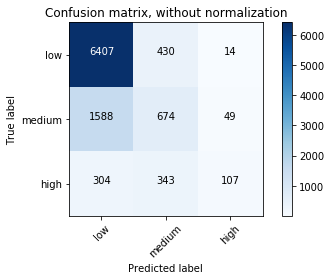

In [100]:
plt.figure()
class_names = ["low", "medium", "high"]
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize = False,
                      title='Confusion matrix, without normalization')

In [101]:
from numpy import log

def log_loss(results_transformed, lables = "label", probability = "probability"):    
    labs_and_preds = results_transformed[lables, probability]
    
    return - labs_and_preds\
                .rdd\
                .map(lambda x: log(x[1][x[0]]))\
                .reduce(lambda x,y: x + y) / labs_and_preds.count()

In [102]:
log_loss(test_results)

0.6276118001607616